(17168,)
(10197, 60, 1)
(1020, 50, 1)
(1, 50, 1)
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Train on 7137 samples, validate on 2040 samples
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/700
7137/7137 [==============================] - 15s 2ms/sample - loss: 0.0338 - last_time_step_mse: 0.0243 - val_loss: 0.0141 - val_last_time_step_mse: 0.0078
Epoch 2/700
7137/7137 [==============================] - 14s 2ms/sample - loss: 0.0121 - last_time_step_mse: 0.0078 - val_loss: 0.0105 - val_last_time_step_mse: 0.0074
Epoch 3/700
7137/7137 [==============================] - 14s 2ms/sample - loss: 0.0098 - last_time_step_mse: 0.0074 - val_loss: 0.0090 - val_last_time_step_mse: 0.0071
Epoch 4/700
7137/7137 [==============================] - 14s 2ms/sample - loss: 0.0086 - last_time_step_mse: 0.0071 - val_loss: 0.0087 - val_last_time_step_mse: 0.0075
Epoch 5/700
7137/71

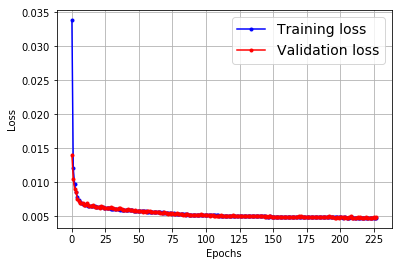

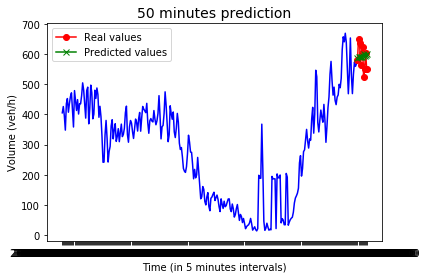

In [0]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import sklearn
import sys
import io

def plot_learning_curves(loss, val_loss):
    plt.figure()
    plt.plot(np.arange(len(loss)), loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)), val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

n_steps = 50
forecast = 10

#EXTRACT FLOW, Z SCORE, OUTLIERS
data_west = pd.read_csv('denoised_data_1015_south.csv')
data_west_o = np.array(data_west.FLOW)
print(data_west_o.shape)

#EXRTEND DATA
array_to_concatinate = data_west_o[177:]
for iter in range (35):
    data_west_o = np.concatenate([data_west_o,array_to_concatinate])

#SCALE AND RESHAPE DATA
scaler = MinMaxScaler()
array = data_west_o.reshape(-1, 1)
array_scaled = scaler.fit_transform(array)

flow_reshaped = array_scaled[:(len(array_scaled) - (len(array_scaled) % (n_steps+forecast)))].reshape(-1, (n_steps+forecast), 1)
print(flow_reshaped.shape)
#TRAIN SET, VALIDATION SET, TEST SET
test = int(0.7 * flow_reshaped.shape[0])
valid = int(0.9 * flow_reshaped.shape[0])

X_train = flow_reshaped[:test, :n_steps]
X_valid = flow_reshaped[test:valid, :n_steps]
X_test = flow_reshaped[valid:, :n_steps]
print(X_test.shape)
print(X_test[-1:].shape)

#prepare targets
Y = np.empty((flow_reshaped.shape[0], n_steps, forecast))
for step_ahead in range(1, forecast + 1):
    Y[:, :, step_ahead - 1] = flow_reshaped[:, step_ahead:step_ahead + n_steps, 0]

y_train = Y[:test]
y_valid = Y[test:valid]
y_test = Y[valid:]

#DEFINE AND COMPILE MODEL
model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(forecast))
])

def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])

early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=700,
                    validation_data=(X_valid, y_valid), callbacks=[early_stopping_cb])

model.save("lstm_1014_south.h5")
plot_learning_curves(history.history["loss"], history.history["val_loss"])

#50 MINS PREDICTION
flow_unscaled = array[:(len(array) - (len(array) % (n_steps + forecast)))].reshape(-1, (n_steps + forecast), 1)
y_test_unscaled = flow_unscaled[valid:, n_steps:, 0]
y_real_rescaled = y_test_unscaled[-1, :].reshape(-1, 1)
print(y_real_rescaled.shape)

flow_not_reshaped = array[:(len(array) - (len(array) % (n_steps+forecast)))]

#flow prediction
y_pred = model.predict(X_test[-1, :].reshape(-1, n_steps, 1)) #shape (1, 50, 10)
y_pred = y_pred[-1,-1,:].reshape(-1,1)
y_pred_rescaled = scaler.inverse_transform(y_pred).reshape(-1, 1) #shape (10, 1)
print(y_pred_rescaled.shape)

#time
time_not_reshaped = np.array(data_west['TIME'][:(len(data_west['TIME']) - (len(data_west['TIME']) % (n_steps+forecast)))])
time_reshaped = np.array(data_west['TIME'][:(len(data_west['TIME']) - (len(data_west['TIME']) % (n_steps+forecast)))]).\
    reshape(-1, (n_steps+forecast), 1)

valid_time = int(0.9 * time_reshaped.shape[0])
y_time_test = time_reshaped[valid_time:, n_steps:, 0]
print(y_time_test[-1, :].shape)

def plot_prediction(y_real_resacled, y_pred_rescaled, flow_not_reshaped, time_not_reshaped, y_time_test):
    plt.figure()
    plt.title("50 minutes prediction", fontsize=14)
    plt.plot(time_not_reshaped[-300:-forecast], flow_not_reshaped[-300:-forecast], 'b-')
    plt.plot(y_time_test[-1, :], y_real_resacled, 'ro-', label = 'Real values')
    plt.plot(y_time_test[-1, :], y_pred_rescaled, 'gx-', label = 'Predicted values')
    plt.legend(loc="upper left")
    plt.xlabel("Time (in 5 minutes intervals)")
    plt.ylabel('Volume (veh/h)')

plot_prediction(y_real_rescaled, y_pred_rescaled, flow_not_reshaped, time_not_reshaped, y_time_test)

plt.show()
